In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/MyDrive/Capstone_project/Dataset_face_disease.zip -d gdrive/MyDrive/Capstone_project/

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [15]:
# Alokasi dataset pada direktori lokal

import pathlib
data_dir = pathlib.Path('gdrive/MyDrive/Capstone_project/Dataset/') 

In [16]:
# Menghitung total dataset gambar

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1588


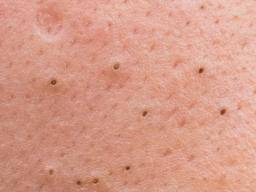

In [17]:
Blackhead = list(data_dir.glob('Blackhead/*'))
PIL.Image.open(str(Blackhead[0]))

In [11]:
from pathlib import Path
import imghdr

# data_dir = "/content/Dataset/"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png", "jpg", "JPG"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

In [29]:
batch_size = 128
img_height = 300
img_width = 300

In [30]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1588 files belonging to 9 classes.
Using 1271 files for training.


In [31]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1588 files belonging to 9 classes.
Using 317 files for validation.


In [32]:
class_names = train_ds.class_names
print(class_names)

['Blackhead', 'Eksim', 'FlekHitam', 'Herves', 'Jerawat', 'Milia', 'Panu', 'Rosacea', 'Tineafasialis']


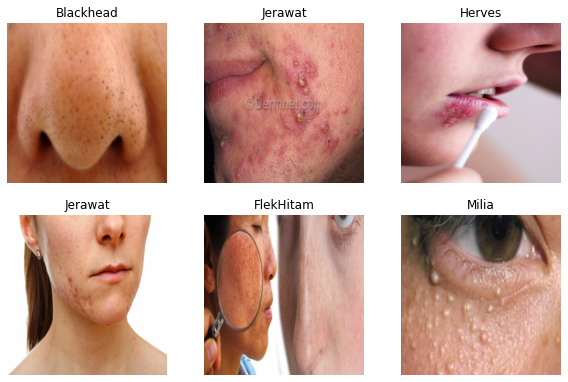

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [34]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(128, 300, 300, 3)
(128,)


In [35]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [36]:
normalization_layer = layers.Rescaling(1./255)

In [51]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [58]:
num_classes = len(class_names)

# resnet_model = Sequential()

# pretrained_model = tf.keras.applications.VGG19(
#     include_top=True,
#     weights="imagenet",
#     input_shape=(img_height,img_width,3),
#     pooling='avg',
#     classes=1000,
#     classifier_activation="softmax",
# )
# for layer in pretrained_model.layers:
#         layer.trainable=False

# resnet_model.add(pretrained_model)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
#  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

In [ ]:
resnet_model.add(Flatten())
resnet_model.add(Dense(64, activation='relu'))
resnet_model.add(Dense(num_classes, activation='softmax'))

In [59]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 300, 300, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 300, 300, 64)      1792      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 150, 150, 64)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 150, 150, 32)      18464     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 75, 75, 16)       

In [60]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy']
)

In [61]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Checkpoint during training for best model
checkpoint = ModelCheckpoint(
    "/content/gdrive/MyDrive/Capstone_project/best_model.h5", 
    monitor='val_accuracy', 
    verbose=2, save_best_only=True, 
    mode='auto'
)

earlyStopping = EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    restore_best_weights=True
)

# reduceLR = ReduceLROnPlateau(
#     monitor='val_accuracy', 
#     factor=0.2,
#     patience=2, 
#     min_lr=0.00001
# )

callback = [checkpoint, earlyStopping]

In [62]:
epochs = 20
history = model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=epochs,
    callbacks=[callback]
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


10/10 [==============================] - ETA: 0s - loss: 2.6068 - accuracy: 0.1873
Epoch 1: val_accuracy improved from -inf to 0.20820, saving model to /content/gdrive/MyDrive/Capstone_project/best_model.h5
10/10 [==============================] - 6s 480ms/step - loss: 2.6068 - accuracy: 0.1873 - val_loss: 2.1328 - val_accuracy: 0.2082
Epoch 2/20
10/10 [==============================] - ETA: 0s - loss: 2.0833 - accuracy: 0.2518
Epoch 2: val_accuracy did not improve from 0.20820
10/10 [==============================] - 2s 242ms/step - loss: 2.0833 - accuracy: 0.2518 - val_loss: 2.0897 - val_accuracy: 0.2082
Epoch 3/20
10/10 [==============================] - ETA: 0s - loss: 2.0306 - accuracy: 0.2746
Epoch 3: val_accuracy improved from 0.20820 to 0.23659, saving model to /content/gdrive/MyDrive/Capstone_project/best_model.h5
10/10 [==============================] - 3s 269ms/step - loss: 2.0306 - accuracy: 0.2746 - val_loss: 2.0962 - val_accuracy: 0.2366
Epoch 4/20
10/10 [================

No handles with labels found to put in legend.
No handles with labels found to put in legend.


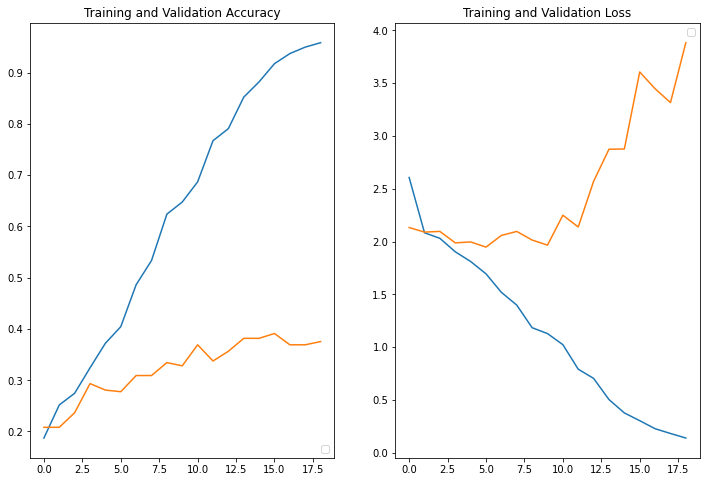

In [66]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [49]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


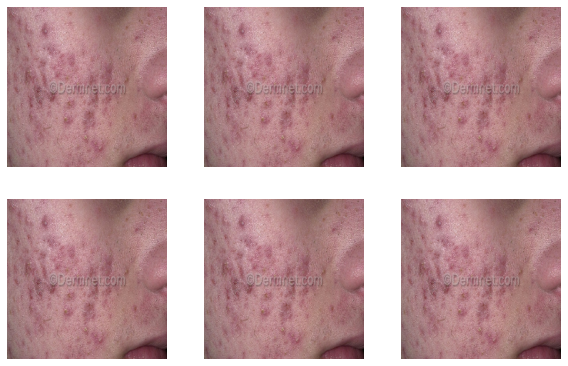

In [35]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(3):
  for i in range(6):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [36]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='relu')
])

In [37]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [38]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 32)      18464     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                  

In [40]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[callback]
)

Epoch 1/50
10/10 [==============================] - 1s 147ms/step - loss: 2.0901 - accuracy: 0.1935 - val_loss: 2.1079 - val_accuracy: 0.2019
Epoch 2/50
10/10 [==============================] - 1s 148ms/step - loss: 2.0830 - accuracy: 0.1998 - val_loss: 2.1420 - val_accuracy: 0.1767
Epoch 3/50
10/10 [==============================] - 1s 147ms/step - loss: 2.0935 - accuracy: 0.1786 - val_loss: 2.0900 - val_accuracy: 0.2618
Epoch 4/50
10/10 [==============================] - 1s 147ms/step - loss: 2.0615 - accuracy: 0.2376 - val_loss: 2.0586 - val_accuracy: 0.2145
Epoch 5/50
10/10 [==============================] - 1s 147ms/step - loss: 2.0414 - accuracy: 0.2313 - val_loss: 2.0703 - val_accuracy: 0.2650
Epoch 6/50
10/10 [==============================] - 1s 149ms/step - loss: 2.0538 - accuracy: 0.2408 - val_loss: 2.0829 - val_accuracy: 0.2334
Epoch 7/50
10/10 [==============================] - 1s 148ms/step - loss: 2.0711 - accuracy: 0.2116 - val_loss: 2.0625 - val_accuracy: 0.2839
Epoch 

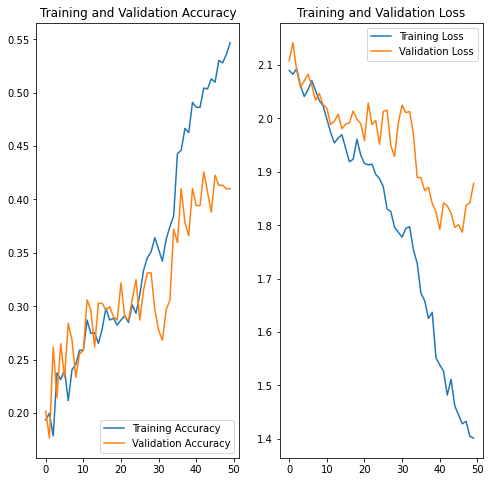

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Save Model To JSON**

In [ ]:
from keras.models import model_from_json

# serialize model to JSON
model_json = model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_json)

# save weights to HDF5
model.save_weights("model.h5")
print("Model saved")

# when you want to retrieve the model: load json and create model
json_file = open('model.json', 'r')
saved_model = json_file.read()
# close the file as good practice
json_file.close()
model_from_json = model_from_json(saved_model)
# load weights into new model
model_from_json.load_weights("model.h5")
print("Model loaded")